<a href="https://www.kaggle.com/code/bekimrexhepi/store-sales-notebook?scriptVersionId=254839253" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 1000)        # wide display
pd.set_option('display.max_colwidth', None) # prevent column truncation



# Preparing The Data

WIth the data provided, I began by only focusing on the year 2017 to increase the speed of learning, also LGBM as a single model by itself gave the best result when focusing only on that year. However, once finishing the notebook for a single model, I attempted a hybrid model to learn from the entire dataset.


* LGBM SINGLE MODEL RESULT (2017 data only): 0.47418
* LGBM + BayesianRidge: 0.48203

Things to Add to increase score:
* Feed Holiday dates into base model and not into the residuals
* Account for transferred holidays = DONE
* Map Regional holidays to actual stores in their respective regional cluster.
* Did not include anything for the magnitude 7.8 earthquake striking Ecuador on April 16, 2016.
* Utilize transactions and oil data in a more useful way, for example, transactions can help model learn which stores are more popular than others

In [3]:
# part 1

holidays_events = pd.read_csv(
    "/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
                         usecols=['store_nbr', 'sales', 'family', 'date', 'onpromotion'],
                        parse_dates=['date'],
                          dtype={
                                'store_nbr': 'category',
                                'family': 'category',
                                'sales': 'float32',
                              'onpromotion': 'uint32'
                            },
                          infer_datetime_format=True
                         )
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr','family', 'date']).sort_index()

average_sales = store_sales.drop('onpromotion', axis=1)
# average_sales = average_sales.groupby('date').mean().squeeze().loc['2017']
average_sales = average_sales.groupby('date').mean().squeeze()
average_sales

/tmp/ipykernel_13/3309101413.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(
/tmp/ipykernel_13/3309101413.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',


date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [4]:
# from sklearn.preprocessing import OneHotEncoder

oil_price = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv',
                       parse_dates=['date'],
                        infer_datetime_format=True
                       )
oil_price['date'] = oil_price.date.dt.to_period('D')
oil_price = oil_price.set_index(['date']).sort_index()
# oil_price = oil_price.loc['2017']

holidays_for_hybrid = (
    holidays_events
    .query("(locale in ['National', 'Regional']) and type in ['Holiday', 'Transfer']")
    .loc['2013':'2017-08-15', ['description', 'locale_name', 'transferred']]
    # .drop_duplicates()
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

# holidays_for_single = (
#     holidays_events
#     .query("locale in ['National', 'Regional']")
#     .loc['2017':'2017-08-15', ['description', 'locale_name']]
#     .drop_duplicates()
#     .assign(description=lambda x: x.description.cat.remove_unused_categories())
# )


onpromo = store_sales.loc[:, 'onpromotion']
# # onpromo = onpromo[onpromo.index.get_level_values('date').year == 2017]

# # sales_2017 = store_sales[store_sales.index.get_level_values('date').year == 2017]
sales_all_years = store_sales[store_sales.index.get_level_values('date').year > 2010]
grouped = sales_all_years.groupby(['store_nbr', 'family'])

# # Create lag and rolling features on 'sales' only
store_sales_lag = pd.DataFrame(index=sales_all_years.index)
store_sales_lag['lag_1'] = grouped['sales'].shift(1)
store_sales_lag['mean_7'] = grouped['sales'].shift(1).rolling(7).mean()
store_sales_lag['median_14'] = grouped['sales'].shift(1).rolling(14).median()
store_sales_lag['std_7'] = grouped['sales'].shift(1).rolling(7).std()
store_sales_lag['promo_7'] = onpromo.rolling(7, center=True).sum()


holidays_without_transfer = holidays_for_hybrid[~holidays_for_hybrid['transferred']]
holiday_days = holidays_without_transfer.index.to_series().dt.strftime('%m-%d').unique()
holiday_mask = store_sales_lag.index.get_level_values('date')\
    .strftime('%m-%d')\
    .isin(holiday_days)
store_sales_lag['is_planned_holiday'] = holiday_mask.astype(int)

holidays_for_hybrid['was_actual_holiday_day'] = ~holidays_for_hybrid[~holidays_for_hybrid['transferred']]['transferred']
holidays_for_hybrid['was_actual_holiday_day'] = holidays_for_hybrid['was_actual_holiday_day'].fillna(False)
store_sales_lag = store_sales_lag.join(holidays_for_hybrid[['was_actual_holiday_day']], on='date', how='left')
store_sales_lag['was_actual_holiday_day'] = store_sales_lag['was_actual_holiday_day'].fillna(False)

# # # Fill missing values
store_sales_lag = store_sales_lag.fillna(0)
store_sales_train = store_sales.copy().drop('onpromotion', axis=1)

/tmp/ipykernel_13/3932037483.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  oil_price = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv',
/tmp/ipykernel_13/3932037483.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sales_all_years.groupby(['store_nbr', 'family'])
/tmp/ipykernel_13/3932037483.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

In [5]:
store_sales_lag

lag_1     mean_7  median_14     std_7  promo_7  is_planned_holiday  was_actual_holiday_day
store_nbr family     date                                                                                                      
1         AUTOMOTIVE 2013-01-01   0.000000   0.000000     0.0000  0.000000      0.0                   1                    True
                     2013-01-02   0.000000   0.000000     0.0000  0.000000      0.0                   1                   False
                     2013-01-03   2.000000   0.000000     0.0000  0.000000      0.0                   0                   False
                     2013-01-04   3.000000   0.000000     0.0000  0.000000      0.0                   0                   False
                     2013-01-05   3.000000   0.000000     0.0000  0.000000      0.0                   0                   False
...                                    ...        ...        ...       ...      ...                 ...                     ...
9         SEAFOOD    2017-08-11  14.350000  17.981428    18.4590  4.595152      4.0                   1                    True
                     2017-08-12  23.830999  19.528714    19.6125  4.459759      4.0                   1                   False
                     2017-08-13  16.859001  19.566000    18.4590  4.432179      0.0                   0                   False
                     2017-08-14  20.000000  18.850428    18.4590  3.760388      0.0                   0                   False
                     2017-08-15  17.000000  17.902857    18.4590  3.138709      0.0                   0                   False

[3000888 rows x 7 columns]

# Plotting Average Sales During the Week

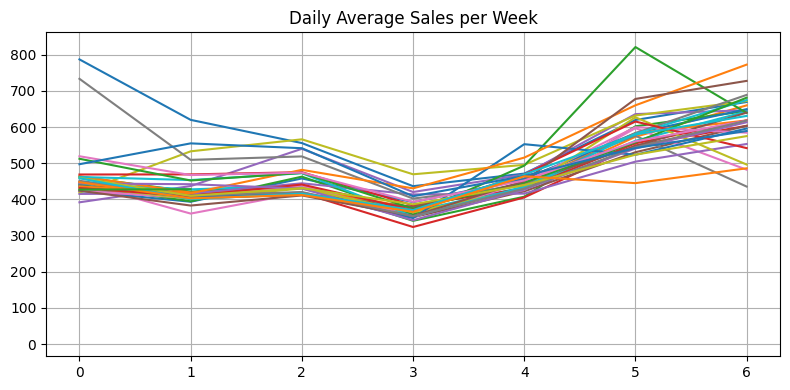

In [6]:
# # part 2a
import matplotlib.pyplot as plt

X = average_sales.loc['2017'].to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

pivoted = X.pivot(index='day', columns='week', values='sales')
pivoted

plt.figure(figsize=(8,4))
for col in pivoted.columns:
    plt.plot(pivoted.index, pivoted[col])

plt.title('Daily Average Sales per Week')
plt.tight_layout()
plt.grid()
plt.show()

# Plotting The Periodogram

The periodogram is one of the most useful plots you can use for a time series problem such as store sales. When you plot a periodogram, it allows you to distinguish what fourier pair order you would like to use when building your deterministic process, without it you are just guessing.

/tmp/ipykernel_13/3326937535.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = 1/freqs


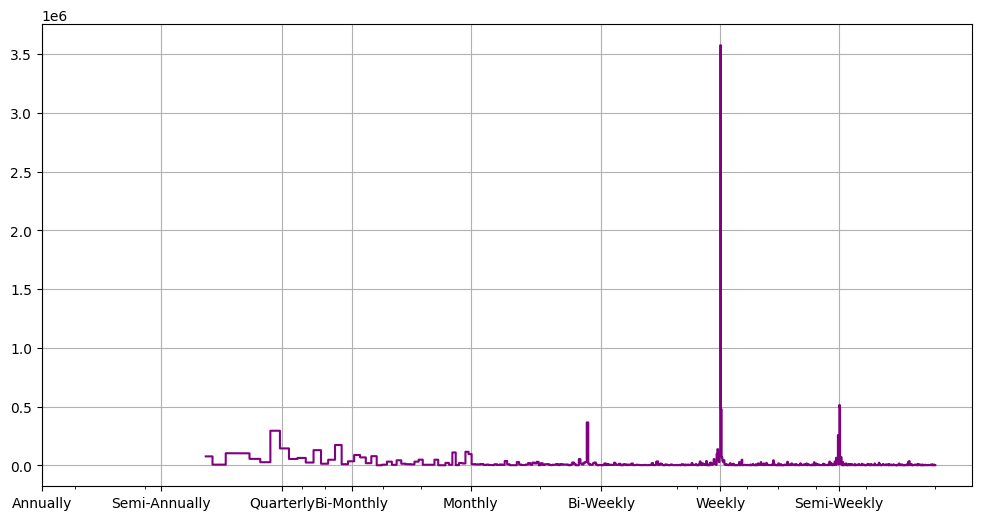

In [7]:
# part 2b
from scipy.signal import periodogram
import matplotlib.pyplot as plt


y = average_sales.asfreq('D').ffill()
freqs, power = periodogram(y)
periods = 1/freqs
valid = (periods < 150) & np.isfinite(periods)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.step(periods[valid], power[valid], where='mid', color='purple')
ax1.set_xscale('log')
ax1.invert_xaxis()

label_values = [365, 182.5, 90, 60, 30, 14, 7, 3.5]
labels = ['Annually', 'Semi-Annually', 'Quarterly', 'Bi-Monthly', 'Monthly', 'Bi-Weekly', 'Weekly', 'Semi-Weekly']

ax1.set_xticks(label_values)
ax1.set_xticklabels(labels)
ax1.grid()

# Plotting Predicted Average vs Real Sales

Having plotted the periodogram, the CalendarFourier can be built and inserted into the DeterministicProcess as per below. We can check the X in sample to see how the model predicted against the real values, joining the holiday and oil datasets with the X in sample will improve the prediction

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1684, number of used features: 16
[LightGBM] [Info] Start training from score 357.775749


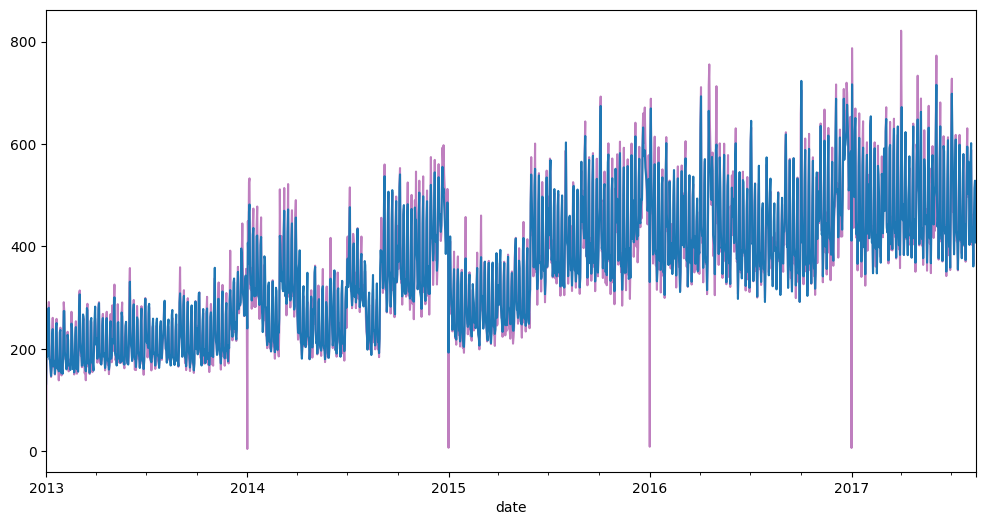

In [8]:
# part 3
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge

y = average_sales.copy()
fourier = CalendarFourier(freq='ME', order=4)
dp = DeterministicProcess(
    index=y.index,
    order=1,
    seasonal=True,
    constant=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X.columns = [c.replace(' ', '_')
               .replace('(', '')
               .replace(')', '')
               .replace('*', '')
               .replace('/', '')
               .replace('[', '')
               .replace(']', '')
               .replace('^', '')
               .replace('{', '')
               .replace('}', '')
               .replace('=', '')
               .replace('<', '')
               .replace('>', '')
               .replace('|', '')
             .replace(',','')
               for c in X.columns]

# holidays_final = pd.get_dummies(holidays_for_single)
# holidays_final = holidays_final.astype(int)
# X_hol = X.join(holidays_final, on='date').fillna(0.0)
# XholOil = X_hol.join(X_oil, on='date').fillna(0)

X_oil = pd.get_dummies(oil_price)
X_oil_join = X.join(X_oil, on='date').fillna(0)


X_oil_join.columns
# model = LinearRegression()
model = LGBMRegressor()
model.fit(X_oil_join, y)
y_pred = pd.Series(model.predict(X_oil_join), index=X_oil_join.index)

plot_params = {
    'figsize': (12, 6),
    'style': '-',
    'color': 'purple'
}

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax)

# Plotting Deseasonality

Following from plotting the initial periodogram, you can now check the residual signal. Kind of like what is left over from the original prediction that the deterministic process could not find a pattern for. It also allows you to see visually how well the deterministic process that you built "cancels out" the original signal

/tmp/ipykernel_13/2701460836.py:4: RuntimeWarning: divide by zero encountered in divide
  period_orig = 1/freqs_orig
/tmp/ipykernel_13/2701460836.py:22: RuntimeWarning: divide by zero encountered in divide
  period_new = 1/freqs_new


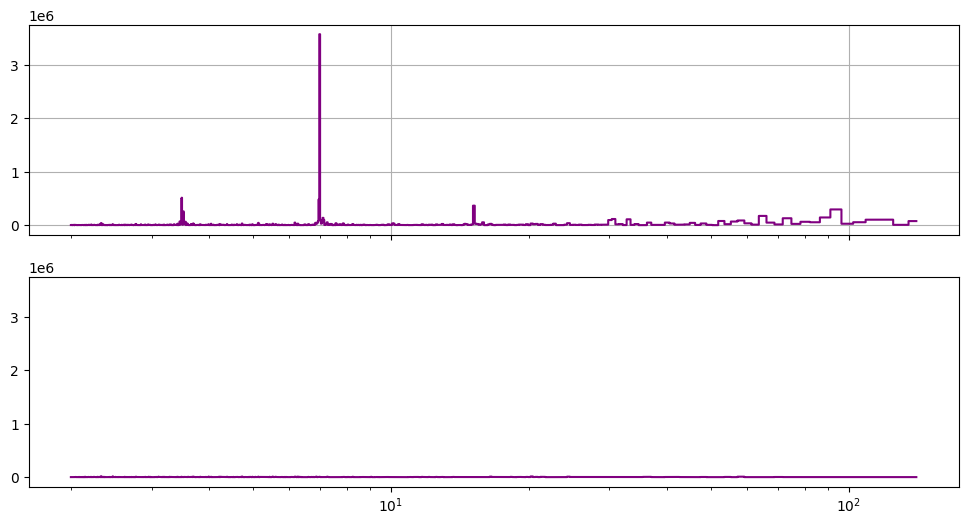

In [9]:

resid = y - y_pred

freqs_orig, power_orig = periodogram(y)
period_orig = 1/freqs_orig
valid_orig = (period_orig < 150) & np.isfinite(period_orig)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(12,6))

ax1.step(period_orig[valid_orig], power_orig[valid_orig], where='mid', color='purple')
ax1.set_xscale('log')
ax1.invert_xaxis()

label_values = [365, 182.5, 90, 60, 30, 14, 7, 3.5]
labels = ['Annually', 'Semi-Annually', 'Quarterly', 'Bi-Monthly', 'Monthly', 'Bi-Weekly', 'Weekly', 'Semi-Weekly']

ax1.set_xticks(label_values)
ax1.set_xticklabels(labels)
ax1.grid()


freqs_new, power_new = periodogram(resid)
period_new = 1/freqs_new
valid_new = (period_new < 150) & np.isfinite(period_new)

ax2.step(period_new[valid_new], power_new[valid_new], where='mid', color='purple')
ax2.set_xscale('log')
ax2.invert_xaxis()


# Building The Hybrid Model

Building hybrid models are useful to attempt to train a second model on the residual signal. The residual signal could be due to cyclical events in the data that can't be found through seasonal trends, or through other extra data that was not included in the first model training. So in this hybrid model, I included lag features and the promotion column


In [10]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.base import clone


class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1_template = model_1
        self.model_2 = model_2
        self.model_1 = {} 
        self.y_columns = None  

    def fit(self, X_1, X_2, y):
        
        if isinstance(self.model_1_template, LGBMRegressor):
            self.model_1 = {}
            y_fit = pd.DataFrame(index=X_1.index, columns=y.columns)
            for col in y.columns:
                model = clone(self.model_1_template)
                model.fit(X_1, y[col].copy())
                y_fit[col] = model.predict(X_1)
                self.model_1[col] = model
                
        else:
            self.model_1.fit(X_1, y)
            y_fit = pd.DataFrame(
                self.model_1.predict(X_1),
                index=X_1.index, columns=y.columns)  
        
        y_resid = y - y_fit
        y_resid = y_resid.stack(['store_nbr', 'family']).squeeze()
    
        self.model_2.fit(X_2, y_resid)
    
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
        
    def predict(self, X_1, X_2):
        if isinstance(self.model_1_template, LGBMRegressor):
            y_pred = pd.DataFrame(index=X_1.index, columns=self.y_columns)
            for col in self.y_columns:
                model = self.model_1[col]
                y_pred[col] = model.predict(X_1)
        else:
            y_pred = pd.DataFrame(
                self.model_1.predict(X_1),
                index=X_1.index, columns=self.y_columns) 
            
        y_pred = y_pred.stack(['store_nbr', 'family']).squeeze()
        y_pred_2 = pd.DataFrame(self.model_2.predict(X_2), index=X_2.index)
        y_pred_2.index = y_pred.index
        y_pred_2 = y_pred_2.squeeze()
        y_pred_new = y_pred + y_pred_2
        
        return y_pred_new.unstack() 

# y = store_sales_train.unstack(['store_nbr', 'family']).loc['2017']
y = store_sales_train.unstack(['store_nbr', 'family'])


fourier = CalendarFourier(freq='ME', order=4)
dp = DeterministicProcess(
    index=y.index,
    order=1,
    seasonal=True,
    constant=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X.columns = [c.replace(' ', '_')
               .replace('(', '')
               .replace(')', '')
               .replace('*', '')
               .replace('/', '')
               .replace('[', '')
               .replace(']', '')
               .replace('^', '')
               .replace('{', '')
               .replace('}', '')
               .replace('=', '')
               .replace('<', '')
               .replace('>', '')
               .replace('|', '')
             .replace(',','')
               for c in X.columns]


X['NewYear'] = (X.index.dayofyear == 1)

# holidays_final = pd.get_dummies(holidays_for_single)
# holidays_final = holidays_final.astype(int)
# X_hol = X.join(holidays_final, on='date').fillna(0.0)
# XholOil = X_hol.join(X_oil, on='date').fillna(0)

X_oil = pd.get_dummies(oil_price)
X_1 = X.join(X_oil, on='date').fillna(0)

X_2 = store_sales_lag
le = LabelEncoder()  
X_2 = X_2.reset_index()
X_2['family'] = le.fit_transform(X_2['family'])
X_2 = X_2.set_index(['store_nbr', 'family', 'date'])
X_2["day"] = X_2.index.get_level_values('date').day

# scaler = StandardScaler()
# X_2_scaled = pd.DataFrame(
#     scaler.fit_transform(X_2),
#     index=X_2.index,
#     columns=X_2.columns
# )


# hybrid_model = BoostedHybrid(LGBMRegressor(verbose=-1), KNeighborsRegressor(n_neighbors=3, weights='distance'))
hybrid_model = BoostedHybrid(LGBMRegressor(verbose=-1), BayesianRidge())


hybrid_model.fit(X_1, X_2, y)
y_pred = hybrid_model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

/tmp/ipykernel_13/758997453.py:34: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack(['store_nbr', 'family']).squeeze()
/tmp/ipykernel_13/758997453.py:53: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack(['store_nbr', 'family']).squeeze()


# Building The Single LGBM Model

The original model. There are a couple of nuances such as having to rename the columns as LGBM cannot handle special characters, furthermore, LGBM needs to go column by column and cannot handle multi output regression, unlike LinearRegression

In [11]:

# y = store_sales.unstack(['store_nbr', 'family']).loc['2017']

# fourier = CalendarFourier(freq='ME', order=4)
# dp = DeterministicProcess(
#     index=y.index,
#     order=1,
#     seasonal=True,
#     constant=True,
#     additional_terms=[fourier],
#     drop=True
# )

# X = dp.in_sample()
# # for lgbm
# X.columns = [c.replace(' ', '_')
#                .replace('(', '')
#                .replace(')', '')
#                .replace('*', '')
#                .replace('/', '')
#                .replace('[', '')
#                .replace(']', '')
#                .replace('^', '')
#                .replace('{', '')
#                .replace('}', '')
#                .replace('=', '')
#                .replace('<', '')
#                .replace('>', '')
#                .replace('|', '')
#              .replace(',','')
#                for c in X.columns]

# X['NewYear'] = (X.index.dayofyear == 1)

# holidays_final = pd.get_dummies(holidays_for_single)
# holidays_final = holidays_final.astype(int)
# X_hol = X.join(holidays_final, on='date').fillna(0.0)
# XholOil = X_hol.join(X_oil, on='date').fillna(0)

# X_oil = pd.get_dummies(oil_price)
# X_1 = X.join(X_oil, on='date').fillna(0)

# # # for lgbm
# models = {}
# y_pred = pd.DataFrame(index=y.index, columns=y.columns)

# for col in y.columns:
#     model = LGBMRegressor(
#         verbose=-1
#     )
#     model.fit(X_1, y[col].copy())
#     y_pred[col] = model.predict(X_1)
#     models[col] = model


# Submission Code For The Single LGBM Model

Submission is basically just a recereation of your of your original feature engineering/data preparation and executing that onto your test set.

In [12]:

# df_test = pd.read_csv(
#     '/kaggle/input/store-sales-time-series-forecasting/test.csv',
#     dtype={
#         'store_nbr': 'category',
#         'family': 'category',
#         'onpromotion': 'uint32',
#     },
#     parse_dates=['date'],
#     infer_datetime_format=True,
# )
# df_test['date'] = df_test.date.dt.to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# X_test  = dp.out_of_sample(steps=16)
# X_test.index.name = 'date' 
# X_test['NewYear'] = (X_test.index.dayofyear == 1)
# X_oil = pd.get_dummies(oil_price)

# X_test.columns = [c.replace(' ', '_')
#                .replace('(', '')
#                .replace(')', '')
#                .replace('*', '')
#                .replace('/', '')
#                .replace('[', '')
#                .replace(']', '')
#                .replace('^', '')
#                .replace('{', '')
#                .replace('}', '')
#                .replace('=', '')
#                .replace('<', '')
#                .replace('>', '')
#                .replace('|', '')
#              .replace(',','')
#                for c in X_test.columns]


## holidays_final = pd.get_dummies(holidays_for_single)
## holidays_final = holidays_final.astype(int)
## X_hol = X.join(holidays_final, on='date').fillna(0.0)
## XholOil = X_hol.join(X_oil, on='date').fillna(0)

# X_oil = pd.get_dummies(oil_price)
# X_test1 = X.join(X_oil, on='date').fillna(0)

# #single model
# y_test_pred = pd.DataFrame(index=X_test1.index, columns=y.columns)

# for col in y.columns:
#     model = models[col]
#     y_test_pred[col] = model.predict(X_test1)

# y_submit = y_test_pred.stack(['store_nbr','family'])
# # y_submit = y_submit.to_frame('sales')
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
# y_submit.to_csv('submission.csv', index=False)
# y_submit

# Submission Code For The Hybrid Model

Because of the lag features and onpromotion columns we added for the hybrid model, we need to concat the test set with the training set. 

In [13]:


df_test = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

X_test  = dp.out_of_sample(steps=16)
X_test.index.name = 'date' 
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_oil = pd.get_dummies(oil_price)

X_test.columns = [c.replace(' ', '_')
               .replace('(', '')
               .replace(')', '')
               .replace('*', '')
               .replace('/', '')
               .replace('[', '')
               .replace(']', '')
               .replace('^', '')
               .replace('{', '')
               .replace('}', '')
               .replace('=', '')
               .replace('<', '')
               .replace('>', '')
               .replace('|', '')
             .replace(',','')
               for c in X_test.columns]

# holidays_final = pd.get_dummies(holidays_for_single)
# holidays_final = holidays_final.astype(int)
# X_hol = X.join(holidays_final, on='date').fillna(0.0)
# XholOil = X_hol.join(X_oil, on='date').fillna(0)

X_oil = pd.get_dummies(oil_price)
X_test1 = X_test.join(X_oil, on='date').fillna(0)


full_sales = pd.concat([
    store_sales[['sales', 'onpromotion']],  # historical sales
    df_test[['onpromotion']].assign(sales=np.nan)  # future periods, no sales
])

# Step 2.2: Recalculate lag features (same code you used in training)
grouped = full_sales.groupby(['store_nbr', 'family'])

lag_features_test = pd.DataFrame(index=full_sales.index)
lag_features_test['lag_1'] = grouped['sales'].shift(1)
lag_features_test['mean_7'] = grouped['sales'].shift(1).rolling(7).mean()
lag_features_test['median_14'] = grouped['sales'].shift(1).rolling(14).median()
lag_features_test['std_7'] = grouped['sales'].shift(1).rolling(7).std()

lag_features_test['promo_7'] = (
    grouped['onpromotion']
    .rolling(7, center=True)
    .sum()
    .reset_index(level=[0, 1], drop=True)
)

holidays_without_transfer = holidays_for_hybrid[~holidays_for_hybrid['transferred']]
holiday_days = holidays_without_transfer.index.to_series().dt.strftime('%m-%d').unique()
holiday_mask = lag_features_test.index.get_level_values('date')\
    .strftime('%m-%d')\
    .isin(holiday_days)
lag_features_test['is_planned_holiday'] = holiday_mask.astype(int)

holidays_for_hybrid['was_actual_holiday_day'] = ~holidays_for_hybrid[~holidays_for_hybrid['transferred']]['transferred']
holidays_for_hybrid['was_actual_holiday_day'] = holidays_for_hybrid['was_actual_holiday_day'].fillna(False)
lag_features_test = lag_features_test.join(holidays_for_hybrid[['was_actual_holiday_day']], on='date', how='left')
lag_features_test['was_actual_holiday_day'] = lag_features_test['was_actual_holiday_day'].fillna(False)


X_test2 = lag_features_test.loc[df_test.index].fillna(0.0)
X_test2 = X_test2.reset_index()
X_test2['family'] = le.transform(X_test2['family'])  # must use trained encoder
X_test2 = X_test2.set_index(['store_nbr', 'family', 'date'])
X_test2['day'] = X_test2.index.get_level_values('date').day

# Predict test sales
y_test_pred = hybrid_model.predict(X_test1, X_test2)
y_test_pred = y_test_pred.clip(0.0)

y_submit = y_test_pred.stack(['family'])
y_submit = y_submit.to_frame('sales')
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)
y_submit

/tmp/ipykernel_13/1007989249.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv(
/tmp/ipykernel_13/1007989249.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_sales = pd.concat([
/tmp/ipykernel_13/1007989249.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = full_sales.groupby(['store_nbr', '

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     3.962504
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.826018
                     BEVERAGES                   3000891  2308.024213
                     BOOKS                       3000892     0.127707
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   432.737184
                     PREPARED FOODS              3029396    98.868163
                     PRODUCE                     3029397  1342.975838
                     SCHOOL AND OFFICE SUPPLIES  3029398    64.954434
                     SEAFOOD                     3029399    16.318810

[28512 rows x 2 columns]